In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from scipy import interpolate
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from scipy import integrate
import astropy.io.fits as fits 
import pandas as pd

F:\Anaconda\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


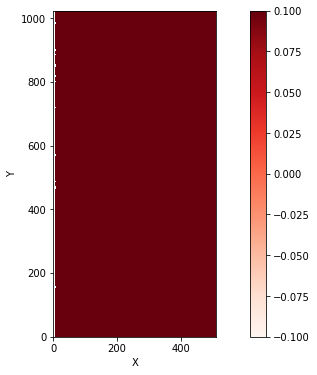

1024
456.31006
294.21515
197.79608


In [2]:
# 导入 fits 文件

import astropy.io.fits as fits 

hdu=fits.open('aJ_asky_991004n0440185.fits')
data=hdu[0].data
header=hdu[0].header

fig=plt.figure(figsize=[12,6])
ax = fig.add_subplot(111)
ax.set_xlabel('X')
ax.set_ylabel('Y')
im=ax.imshow(data,cmap='Reds',origin='low')
fig.colorbar(im, ax=ax)
im.set_clim(0,np.percentile(data.flatten(),98))
plt.show()

print (len(data))
print (data[294, 458])  # pixel 行、列值减一（pyhton list index 从零开始）
print (data[236, 460])
print (data[113, 124])

456.31006


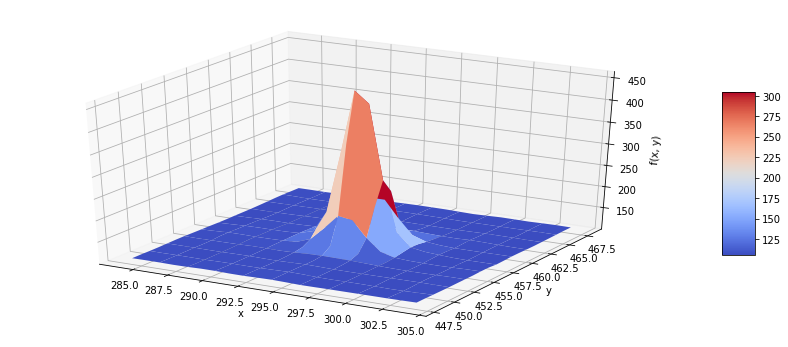

In [3]:
# 将fits文件中的 data 转为函数，以便插值

def data_func(x,y):
    return data[x,y]
print (data_func(294, 458))

# 选较小区域（20*20）
x = np.arange(284, 305, 1)
y = np.arange(448, 469, 1)
x, y = np.meshgrid(x, y)

fvals = data_func(x,y)

fig = plt.figure(figsize=(15, 6))
ax=plt.subplot(111,projection = '3d')
surf = ax.plot_surface(x, y, fvals, rstride=2, cstride=2, cmap=cm.coolwarm,linewidth=0.5, antialiased=True)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
plt.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [4]:
'''
# 交互式画图检查

%matplotlib auto
plt.ion()
fig = plt.figure(figsize=(15, 6))
ax=plt.subplot(111,projection = '3d')
surf = ax.plot_surface(x, y, fvals, rstride=2, cstride=2, cmap=cm.coolwarm,linewidth=0.5, antialiased=True)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
plt.colorbar(surf, shrink=0.5, aspect=5)
'''

"\n# 交互式画图检查\n\n%matplotlib auto\nplt.ion()\nfig = plt.figure(figsize=(15, 6))\nax=plt.subplot(111,projection = '3d')\nsurf = ax.plot_surface(x, y, fvals, rstride=2, cstride=2, cmap=cm.coolwarm,linewidth=0.5, antialiased=True)\nax.set_xlabel('x')\nax.set_ylabel('y')\nax.set_zlabel('f(x, y)')\nplt.colorbar(surf, shrink=0.5, aspect=5)\n"

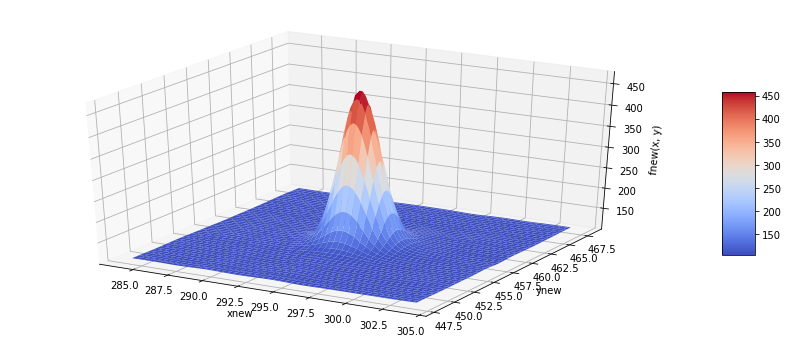

In [5]:
# 二维插值

x = np.arange(284, 305, 1)
y = np.arange(448, 469, 1)
new_data_func = interpolate.interp2d(x, y, fvals, kind='cubic')

xnew = np.linspace(284, 304, 100)
ynew = np.linspace(448, 468, 100)
fnew = new_data_func(xnew, ynew)
xnew, ynew = np.meshgrid(xnew, ynew)

fig = plt.figure(figsize=(15, 6))
ax2=plt.subplot(111,projection = '3d')
surf2 = ax2.plot_surface(xnew, ynew, fnew, rstride=2, cstride=2, cmap=cm.coolwarm,linewidth=0.5, antialiased=True)
ax2.set_xlabel('xnew')
ax2.set_ylabel('ynew')
ax2.set_zlabel('fnew(x, y)')
plt.colorbar(surf2, shrink=0.5, aspect=5)# 标注
plt.show()

F:\Anaconda\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


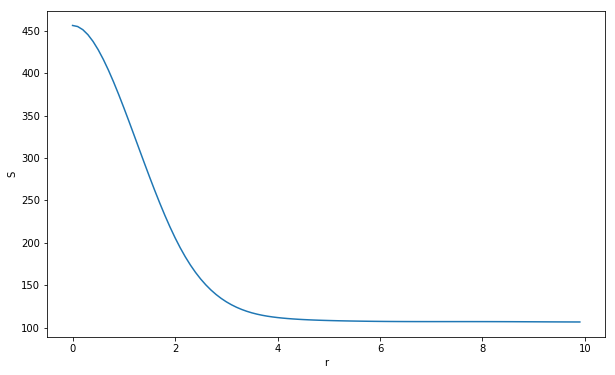

In [6]:
# 积分得到一维曲线

center = [294, 458]
S1 = [data[294, 458]]
r1 = [0]

R = 10  # 最大半径
N = 100  # 取值个数
for i in range(1, N):
    r_new = i*R/N
    r1.append(r_new)
    def data_func_theta(theta):
        return r_new * new_data_func(center[0] + r_new*np.cos(theta), center[1] + r_new*np.sin(theta))
    S_new = integrate.quad(data_func_theta, 0, 2*np.pi)[0]
    S1.append(S_new/(2*np.pi*r_new))

fig = plt.figure(figsize=(10, 6))
ax=plt.subplot(111)
ax.plot(r1, S1)
ax.set_xlabel('r')
ax.set_ylabel('S')
plt.show()

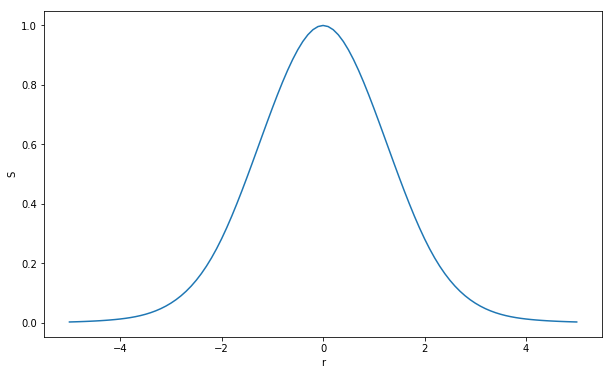

In [7]:
# 去除背景，得到一维曲线


r1_back = []
S1_back = []
for i in range(len(r1)):
    if r1[i] >= 5:
        r1_back.append(r1[i])
        S1_back.append(S1[i])
        
back1 = np.mean(S1_back)
S1_new = [a-back1 for a in S1]

r1_source = []
S1_source = []
for i in range(len(r1)):
    if r1[i] <= 5:
        r1_source.append(r1[i])
        S1_source.append(S1_new[i])
L = len(r1_source)
for i in range(1, L):
    r1_source.insert(0,-r1[i])
    S1_source.insert(0,S1_new[i])
S1_source = [a/max(S1_source) for a in S1_source]

fig = plt.figure(figsize=(10, 6))
ax=plt.subplot(111)
ax.plot(r1_source, S1_source)
ax.set_xlabel('r')
ax.set_ylabel('S')
plt.show()

S_list = []
S_list.append(S1_source)

def y_low(x):
    return -(25-x**2)**0.5
def y_high(x):
    return (25-x**2)**0.5
S1_int = integrate.dblquad(new_data_func, -5, 5, y_low, y_high)[0]
S_int_list=[S1_int]

F:\Anaconda\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


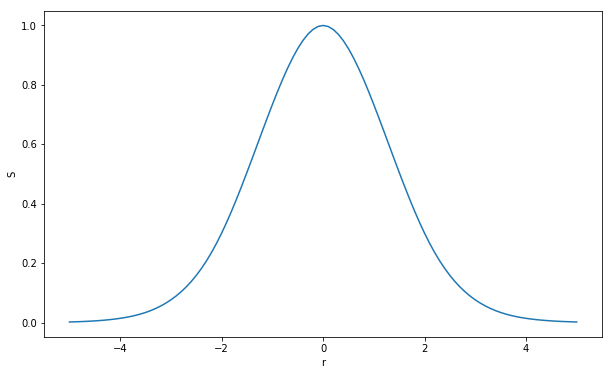

In [8]:
# 第二个源

center = [236, 460]
S2 = [data[236, 460]]
r2 = [0]

x = np.arange(226, 247, 1)
y = np.arange(450, 471, 1)
x, y = np.meshgrid(x, y)
fvals = data_func(x,y)

x = np.arange(226, 247, 1)
y = np.arange(450, 471, 1)
new_data_func = interpolate.interp2d(x, y, fvals, kind='cubic')
xnew = np.linspace(226, 246, 100)
ynew = np.linspace(450, 470, 100)
fnew = new_data_func(xnew, ynew)

R = 10  # 最大半径
N = 100  # 取值个数
for i in range(1, N):
    r_new = i*R/N
    r2.append(r_new)
    def data_func_theta(theta):
        return r_new * new_data_func(center[0] + r_new*np.cos(theta), center[1] + r_new*np.sin(theta))
    S_new = integrate.quad(data_func_theta, 0, 2*np.pi)[0]
    S2.append(S_new/(2*np.pi*r_new))
    
r2_back = []
S2_back = []
for i in range(len(r2)):
    if r2[i] >= 5:
        r2_back.append(r2[i])
        S2_back.append(S2[i])        
back2 = np.mean(S2_back)
S2_new = [a-back2 for a in S2]

r2_source = []
S2_source = []
for i in range(len(r2)):
    if r2[i] <= 5:
        r2_source.append(r2[i])
        S2_source.append(S2_new[i])
L = len(r2_source)
for i in range(1, L):
    r2_source.insert(0,-r2[i])
    S2_source.insert(0,S2_new[i])
S2_source = [a/max(S2_source) for a in S2_source]

fig = plt.figure(figsize=(10, 6))
ax=plt.subplot(111)
ax.plot(r2_source, S2_source)
ax.set_xlabel('r')
ax.set_ylabel('S')
plt.show()

S_list.append(S2_source)
S2_int = integrate.dblquad(new_data_func, -5, 5, y_low, y_high)[0]
S_int_list.append(S2_int)

F:\Anaconda\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


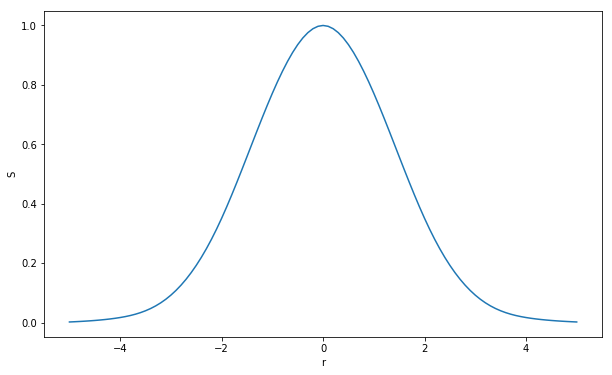

In [9]:
# 第三个源

center = [113, 124]
S3 = [data[113, 124]]
r3 = [0]

x = np.arange(103, 124, 1)
y = np.arange(114, 135, 1)
x, y = np.meshgrid(x, y)
fvals = data_func(x,y)

x = np.arange(103, 124, 1)
y = np.arange(114, 135, 1)
new_data_func = interpolate.interp2d(x, y, fvals, kind='cubic')
xnew = np.linspace(103, 123, 100)
ynew = np.linspace(114, 134, 100)
fnew = new_data_func(xnew, ynew)

R = 10  # 最大半径
N = 100  # 取值个数
for i in range(1, N):
    r_new = i*R/N
    r3.append(r_new)
    def data_func_theta(theta):
        return r_new * new_data_func(center[0] + r_new*np.cos(theta), center[1] + r_new*np.sin(theta))
    S_new = integrate.quad(data_func_theta, 0, 2*np.pi)[0]
    S3.append(S_new/(2*np.pi*r_new))
    
r3_back = []
S3_back = []
for i in range(len(r3)):
    if r3[i] >= 5:
        r3_back.append(r3[i])
        S3_back.append(S3[i])        
back3 = np.mean(S3_back)
S3_new = [a-back3 for a in S3]

r3_source = []
S3_source = []
for i in range(len(r3)):
    if r3[i] <= 5:
        r3_source.append(r3[i])
        S3_source.append(S3_new[i])
L = len(r3_source)
for i in range(1, L):
    r3_source.insert(0,-r3[i])
    S3_source.insert(0,S3_new[i])
S3_source = [a/max(S3_source) for a in S3_source]

fig = plt.figure(figsize=(10, 6))
ax=plt.subplot(111)
ax.plot(r3_source, S3_source)
ax.set_xlabel('r')
ax.set_ylabel('S')
plt.show()

S_list.append(S3_source)
S3_int = integrate.dblquad(new_data_func, -5, 5, y_low, y_high)[0]
S_int_list.append(S3_int)

In [10]:
# 数据导出

datalist = {'r':r1_source, 'S1':S_list[0], 'S2':S_list[1], 'S3':S_list[2], 
            'S1_int':S_int_list[0], 'S2_int':S_int_list[1], 'S3_int':S_int_list[2]}
test = pd.DataFrame(datalist,columns = ['r','S1','S2','S3','S1_int','S2_int','S3_int'])
test.to_csv('data_addition.csv')

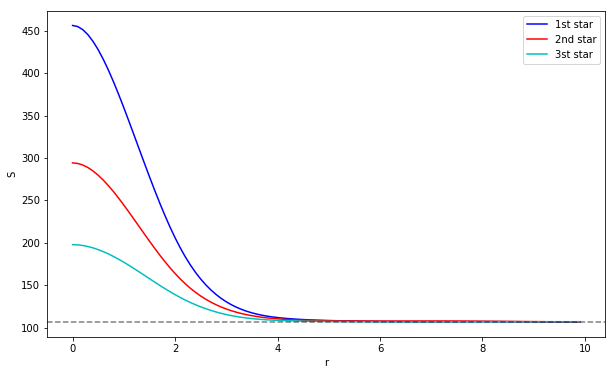

In [11]:
back_g1 = (back1+back2+back3)/3

fig = plt.figure(figsize=(10, 6))
ax=plt.subplot(111)
ax.plot(r1, S1, '-b', label='1st star')
ax.plot(r2, S2, '-r', label='2nd star')
ax.plot(r3, S3, '-c', label='3st star')
ax.axhline(y=back_g1, color='k', alpha=0.5, linestyle='--')
ax.legend(loc = 'upper right')
ax.set_xlabel('r')
ax.set_ylabel('S')
plt.show()

In [12]:
# recommend

print (data[113, 262])  # pixel 行、列值减一（pyhton list index 从零开始）
print (data[20, 226])
print (data[90, 165])

145.35414
145.2034
127.057335


F:\Anaconda\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


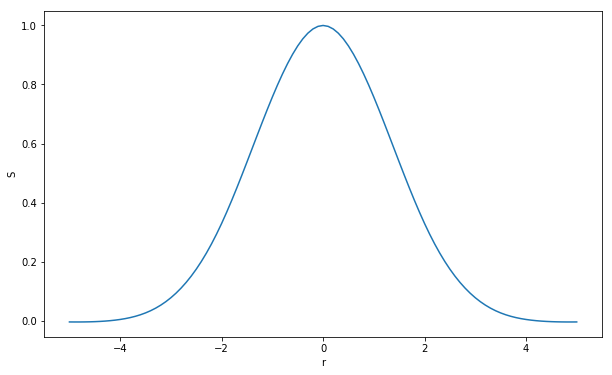

In [13]:
# recommend 1

center = [113, 262]
S1 = [data[113, 262]]
r1 = [0]

x = np.arange(103, 124, 1)
y = np.arange(252, 273, 1)
x, y = np.meshgrid(x, y)
fvals = data_func(x,y)

x = np.arange(103, 124, 1)
y = np.arange(252, 273, 1)
new_data_func = interpolate.interp2d(x, y, fvals, kind='cubic')
xnew = np.linspace(103, 123, 100)
ynew = np.linspace(252, 272, 100)
fnew = new_data_func(xnew, ynew)

R = 10  # 最大半径
N = 100  # 取值个数
for i in range(1, N):
    r_new = i*R/N
    r1.append(r_new)
    def data_func_theta(theta):
        return r_new * new_data_func(center[0] + r_new*np.cos(theta), center[1] + r_new*np.sin(theta))
    S_new = integrate.quad(data_func_theta, 0, 2*np.pi)[0]
    S1.append(S_new/(2*np.pi*r_new))
    
r1_back = []
S1_back = []
for i in range(len(r1)):
    if r1[i] >= 5:
        r1_back.append(r1[i])
        S1_back.append(S1[i])        
back1 = np.mean(S1_back)
S1_new = [a-back1 for a in S1]

r1_source = []
S1_source = []
for i in range(len(r1)):
    if r1[i] <= 5:
        r1_source.append(r1[i])
        S1_source.append(S1_new[i])
L = len(r1_source)
for i in range(1, L):
    r1_source.insert(0,-r1[i])
    S1_source.insert(0,S1_new[i])
S1_source = [a/max(S1_source) for a in S1_source]

fig = plt.figure(figsize=(10, 6))
ax=plt.subplot(111)
ax.plot(r1_source, S1_source)
ax.set_xlabel('r')
ax.set_ylabel('S')
plt.show()

S_list.append(S1_source)
S1_int = integrate.dblquad(new_data_func, -5, 5, y_low, y_high)[0]
S_int_list.append(S1_int)

F:\Anaconda\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


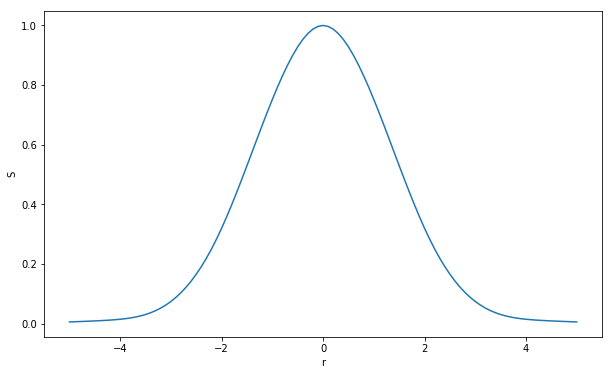

In [14]:
# recommend 2

center = [20, 226]
S2 = [data[20, 226]]
r2 = [0]

x = np.arange(10, 31, 1)
y = np.arange(216, 237, 1)
x, y = np.meshgrid(x, y)
fvals = data_func(x,y)

x = np.arange(10, 31, 1)
y = np.arange(216, 237, 1)
new_data_func = interpolate.interp2d(x, y, fvals, kind='cubic')
xnew = np.linspace(10, 30, 100)
ynew = np.linspace(216, 236, 100)
fnew = new_data_func(xnew, ynew)

R = 10  # 最大半径
N = 100  # 取值个数
for i in range(1, N):
    r_new = i*R/N
    r2.append(r_new)
    def data_func_theta(theta):
        return r_new * new_data_func(center[0] + r_new*np.cos(theta), center[1] + r_new*np.sin(theta))
    S_new = integrate.quad(data_func_theta, 0, 2*np.pi)[0]
    S2.append(S_new/(2*np.pi*r_new))
    
r2_back = []
S2_back = []
for i in range(len(r2)):
    if r2[i] >= 5:
        r2_back.append(r2[i])
        S2_back.append(S2[i])        
back2 = np.mean(S2_back)
S2_new = [a-back2 for a in S2]

r2_source = []
S2_source = []
for i in range(len(r2)):
    if r2[i] <= 5:
        r2_source.append(r2[i])
        S2_source.append(S2_new[i])
L = len(r2_source)
for i in range(1, L):
    r2_source.insert(0,-r2[i])
    S2_source.insert(0,S2_new[i])
S2_source = [a/max(S2_source) for a in S2_source]

fig = plt.figure(figsize=(10, 6))
ax=plt.subplot(111)
ax.plot(r2_source, S2_source)
ax.set_xlabel('r')
ax.set_ylabel('S')
plt.show()

S_list.append(S2_source)
S2_int = integrate.dblquad(new_data_func, -5, 5, y_low, y_high)[0]
S_int_list.append(S2_int)

F:\Anaconda\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


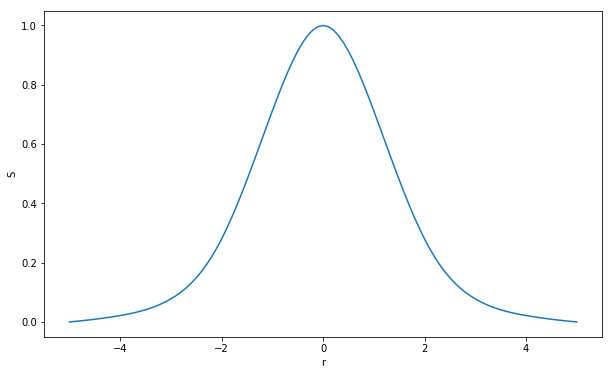

In [15]:
# recommend 3

center = [90, 165]
S3 = [data[90, 165]]
r3 = [0]

x = np.arange(80, 101, 1)
y = np.arange(155, 176, 1)
x, y = np.meshgrid(x, y)
fvals = data_func(x,y)

x = np.arange(80, 101, 1)
y = np.arange(155, 176, 1)
new_data_func = interpolate.interp2d(x, y, fvals, kind='cubic')
xnew = np.linspace(80, 100, 100)
ynew = np.linspace(155, 175, 100)
fnew = new_data_func(xnew, ynew)

R = 10  # 最大半径
N = 100  # 取值个数
for i in range(1, N):
    r_new = i*R/N
    r3.append(r_new)
    def data_func_theta(theta):
        return r_new * new_data_func(center[0] + r_new*np.cos(theta), center[1] + r_new*np.sin(theta))
    S_new = integrate.quad(data_func_theta, 0, 2*np.pi)[0]
    S3.append(S_new/(2*np.pi*r_new))
    
r3_back = []
S3_back = []
for i in range(len(r3)):
    if r3[i] >= 5:
        r3_back.append(r3[i])
        S3_back.append(S3[i])        
back3 = np.mean(S3_back)
S3_new = [a-back3 for a in S3]

r3_source = []
S3_source = []
for i in range(len(r3)):
    if r3[i] <= 5:
        r3_source.append(r3[i])
        S3_source.append(S3_new[i])
L = len(r3_source)
for i in range(1, L):
    r3_source.insert(0,-r3[i])
    S3_source.insert(0,S3_new[i])
S3_source = [a/max(S3_source) for a in S3_source]

fig = plt.figure(figsize=(10, 6))
ax=plt.subplot(111)
ax.plot(r3_source, S3_source)
ax.set_xlabel('r')
ax.set_ylabel('S')
plt.show()

S_list.append(S3_source)
S3_int = integrate.dblquad(new_data_func, -5, 5, y_low, y_high)[0]
S_int_list.append(S3_int)

In [16]:
# 数据导出

datalist = {'r':r1_source, 'S1':S_list[0], 'S2':S_list[1], 'S3':S_list[2], 
            'S1_int':S_int_list[0], 'S2_int':S_int_list[1], 'S3_int':S_int_list[2]}
test = pd.DataFrame(datalist,columns = ['r','S1','S2','S3','S1_int','S2_int','S3_int'])
test.to_csv('data_reccommend.csv')

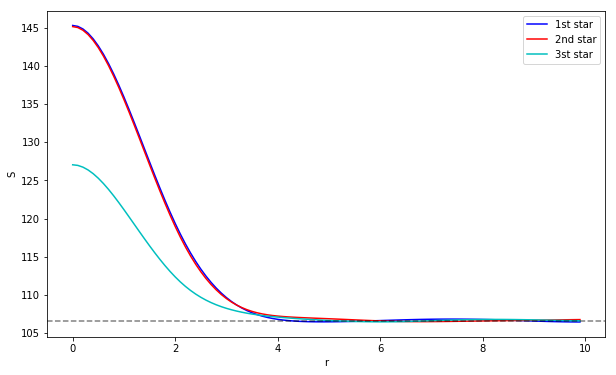

In [17]:
back_g2 = (back1+back2+back3)/3

fig = plt.figure(figsize=(10, 6))
ax=plt.subplot(111)
ax.plot(r1, S1, '-b', label='1st star')
ax.plot(r2, S2, '-r', label='2nd star')
ax.plot(r3, S3, '-c', label='3st star')
ax.axhline(y=back_g2, color='k', alpha=0.5, linestyle='--')
ax.legend(loc = 'upper right')
ax.set_xlabel('r')
ax.set_ylabel('S')
plt.show()